<a href="https://colab.research.google.com/github/gustavo159753/Analise-de-dados/blob/main/mcda_ANALISYS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "numpy<2"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
glue-vispy-viewers 1.2.3 requires glfw, which is not installed.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 12.1.1 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.



  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


Buscando dados em tempo real para: ['LMT', 'RTX', 'NOC', 'GD', 'BA', 'AVAV', 'MP', 'LYSCF', 'PLTR', 'XOM']...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed



MATRIZ DE DECISÃO (VALORES REAIS DE MERCADO)
        Retorno_Acum  Volatilidade  Sharpe_Ratio  Max_Drawdown
Ticker                                                        
AVAV          3.3548        0.5469        6.1337       -0.6101
BA            0.3944        0.3754        1.0506       -0.5696
GD            1.8526        0.2030        9.1255       -0.2255
LMT           0.9913        0.2230        4.4451       -0.3179
LYSCF         5.6964        0.5243       10.8654       -0.5789
MP            3.1016        0.7310        4.2432       -0.8199
NOC           1.5083        0.2455        6.1437       -0.2228
PLTR         12.7474        0.7055       18.0683       -0.8462
RTX           2.9775        0.2490       11.9581       -0.3284
XOM           4.5394        0.2851       15.9234       -0.2051

Erro no método SPOTIS: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 4


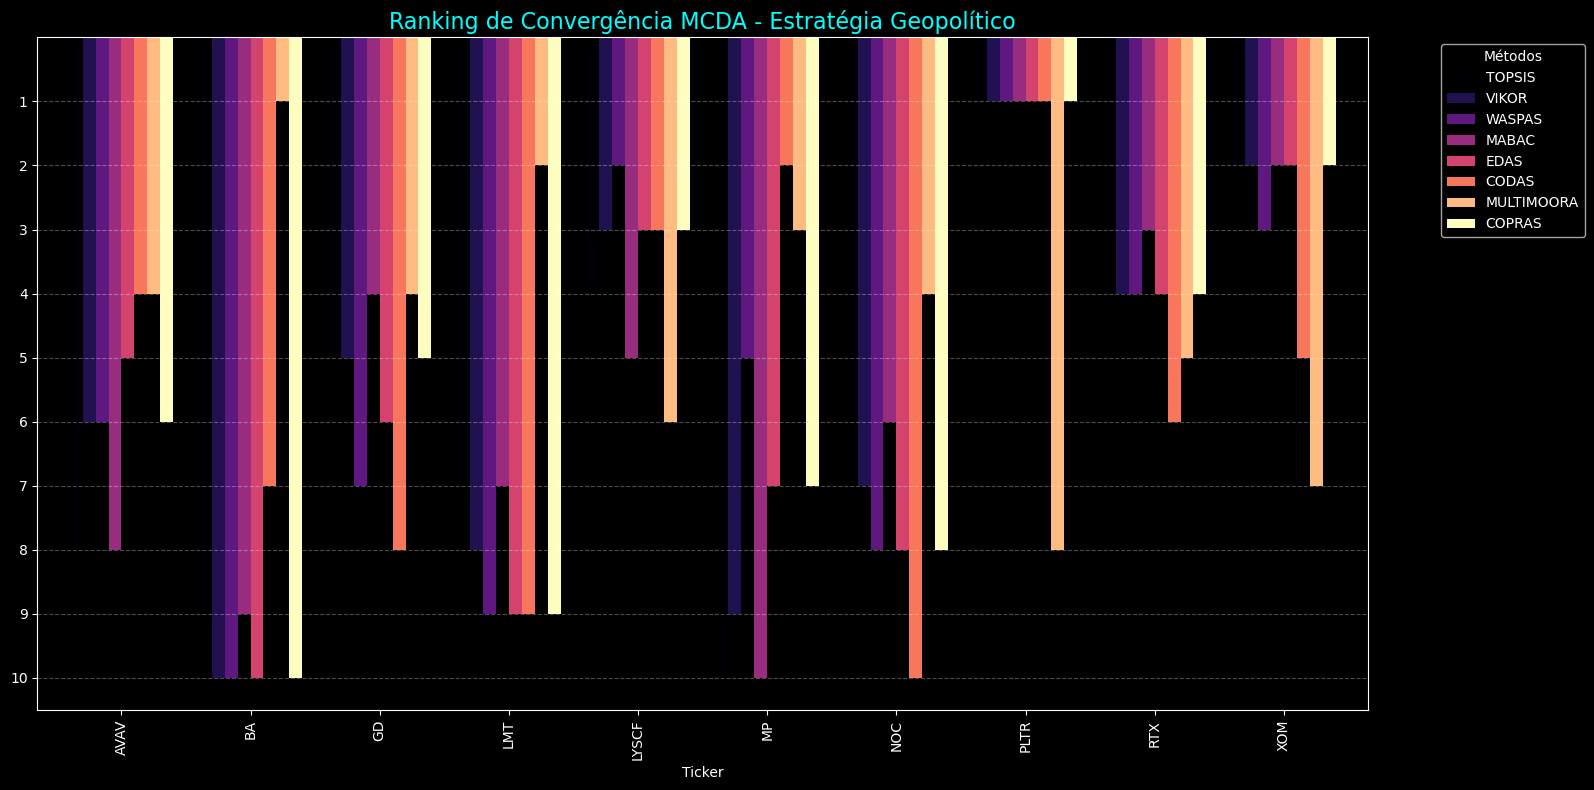


--- RANKING FINAL (CONSENSO GEOPOLÍTICO) ---
Ticker
PLTR      1
XOM       2
LYSCF     3
RTX       4
GD        5
AVAV      6
MP        7
NOC       8
LMT       9
BA       10
Name: FINAL_RANK, dtype: int32


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrepo_mcda.mcda_methods import (
    TOPSIS, VIKOR, SPOTIS, WASPAS, MABAC,
    EDAS, CODAS, MULTIMOORA, COPRAS
)
from pyrepo_mcda.additions import rank_preferences

# 1. Definição dos Tickers Estratégicos
tickers = [
    'LMT', 'RTX', 'NOC', 'GD',    # Bélica/Defesa
    'BA', 'AVAV',                 # Espacial/Drones
    'MP', 'LYSCF',                # Terras Raras
    'PLTR', 'XOM'                 # Inteligência/Energia
]

print(f"Buscando dados em tempo real para: {tickers}...")
df_prices = yf.download(tickers, period='10y')['Close'].dropna()

# 2. Cálculo dos Critérios (Construção da Matriz)
returns = df_prices.pct_change().dropna()
c1_ret = (df_prices.iloc[-1] / df_prices.iloc[0]) - 1          # Retorno Acumulado
c2_vol = returns.std() * np.sqrt(252)                         # Volatilidade Anualizada
c3_sha = c1_ret / c2_vol                                      # Índice Sharpe
c4_mdd = (df_prices / df_prices.cummax() - 1).min()            # Max Drawdown

# Criando um DataFrame para a Matriz de Decisão
decision_matrix_df = pd.DataFrame({
    'Retorno_Acum': c1_ret,
    'Volatilidade': c2_vol,
    'Sharpe_Ratio': c3_sha,
    'Max_Drawdown': c4_mdd
}, index=df_prices.columns)

# --- PRINT DA MATRIZ CRIADA ---
print("\n" + "="*70)
print("MATRIZ DE DECISÃO (VALORES REAIS DE MERCADO)")
print("="*70)
print(decision_matrix_df.round(4))
print("="*70 + "\n")

# Convertendo para NumPy para o processamento
matrix = decision_matrix_df.values
weights = np.array([0.35, 0.15, 0.35, 0.15])
# 1 para Maximização, -1 para Minimização
types = np.array([1, -1, 1, 1])

# 3. Configuração de Métodos
methods_config = {
    "TOPSIS": (TOPSIS(), True),
    "VIKOR": (VIKOR(), False),
    "SPOTIS": (SPOTIS(), False),
    "WASPAS": (WASPAS(), True),
    "MABAC": (MABAC(), True),
    "EDAS": (EDAS(), True),
    "CODAS": (CODAS(), True),
    "MULTIMOORA": (MULTIMOORA(), True),
    "COPRAS": (COPRAS(), True)
}

df_ranks = pd.DataFrame(index=decision_matrix_df.index)

# 4. Execução dos Métodos com Correção para o SPOTIS
for name, (method, is_reverse) in methods_config.items():
    try:
        if name == "SPOTIS":
            bounds = np.vstack([
                matrix.min(axis=0),
                matrix.max(axis=0)
            ]).T
            pref = method(matrix, weights, types, bounds)
        else:
            pref = method(matrix, weights, types)

        df_ranks[name] = rank_preferences(pref, reverse=is_reverse)
    except Exception as e:
        print(f"Erro no método {name}: {e}")

# 5. Visualização e Gráfico
plt.style.use('dark_background')
ax = df_ranks.plot(kind='bar', figsize=(16, 8), width=0.8, colormap='magma')
plt.title('Ranking de Convergência MCDA - Estratégia Geopolítico', fontsize=16, color='cyan')
plt.gca().invert_yaxis()
plt.yticks(range(1, len(tickers) + 1))
plt.legend(title='Métodos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Resultado Consolidado
df_ranks['MEDIA_RANK'] = df_ranks.mean(axis=1)
df_ranks['FINAL_RANK'] = df_ranks['MEDIA_RANK'].rank().astype(int)
print("\n--- RANKING FINAL (CONSENSO GEOPOLÍTICO) ---")
print(df_ranks['FINAL_RANK'].sort_values())

In [ ]:
import pyrepo_mcda
print(dir(pyrepo_mcda))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'additions', 'compromise_rankings', 'correlations', 'distance_metrics', 'mcda_methods', 'normalizations', 'sensitivity_analysis_weights_percentages', 'sensitivity_analysis_weights_values', 'weighting_methods']



Análise de Sensibilidade: Retorno (C1)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       7 |      7 |     6 |
| $A_{2}$           |     9 |     9 |     9 |    9 |    9 |     10 |   10 |      10 |     10 |    10 |
| $A_{3}$           |     4 |     4 |     4 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       8 |      8 |     8 |
| $A_{5}$           |     5 |     5 |     5 |    4 |    4 |      3 |    3 |       3 |      3 |     3 |
| $A_{6}$           |    10 |    10 |    10 |   10 |   10 |      9 |    9 |       9 |      9 |     9 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     7 |
| $A_{8}$           |     3 |    

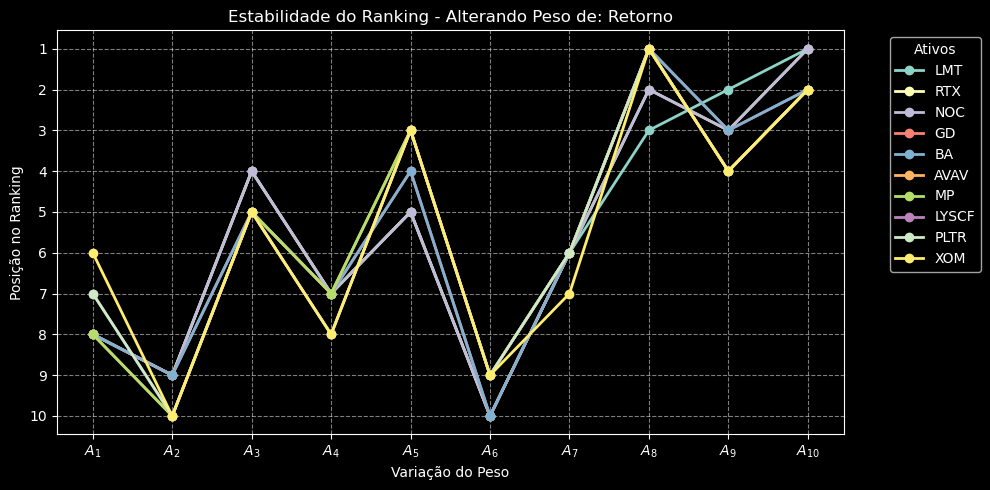


Análise de Sensibilidade: Volatilidade (C2)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     7 |     8 |     8 |    8 |    8 |      8 |    8 |       8 |      8 |     8 |
| $A_{2}$           |    10 |    10 |    10 |   10 |    9 |      9 |    9 |       9 |      9 |     9 |
| $A_{3}$           |     5 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     8 |     7 |     7 |    7 |    7 |      7 |    7 |       7 |      7 |     7 |
| $A_{5}$           |     3 |     3 |     3 |    3 |    4 |      4 |    4 |       4 |      4 |     4 |
| $A_{6}$           |     9 |     9 |     9 |    9 |   10 |     10 |   10 |      10 |     10 |    10 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     1 

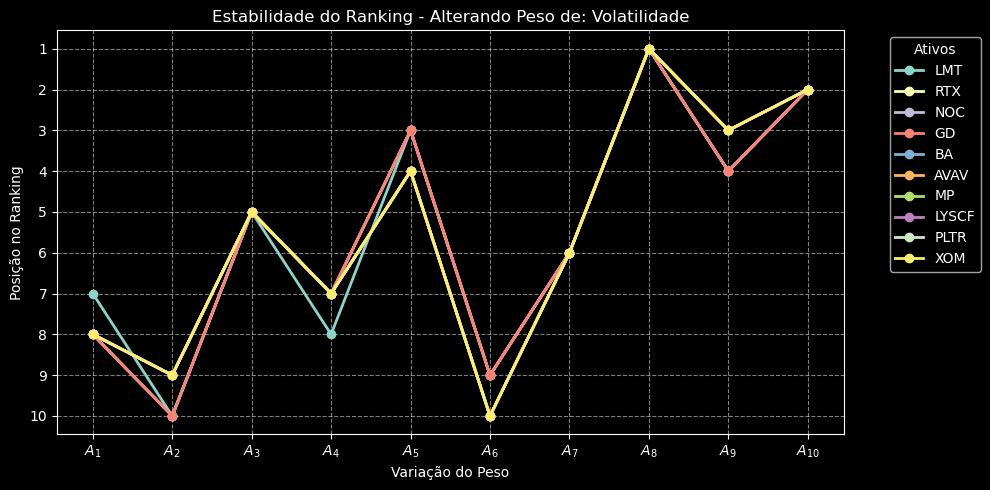


Análise de Sensibilidade: Sharpe (C3)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       7 |      7 |     7 |
| $A_{2}$           |     9 |     9 |     9 |    9 |    9 |     10 |   10 |      10 |     10 |    10 |
| $A_{3}$           |     4 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       8 |      8 |     8 |
| $A_{5}$           |     5 |     4 |     4 |    4 |    4 |      4 |    4 |       4 |      4 |     4 |
| $A_{6}$           |    10 |    10 |    10 |   10 |   10 |      9 |    9 |       9 |      9 |     9 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     1 |     

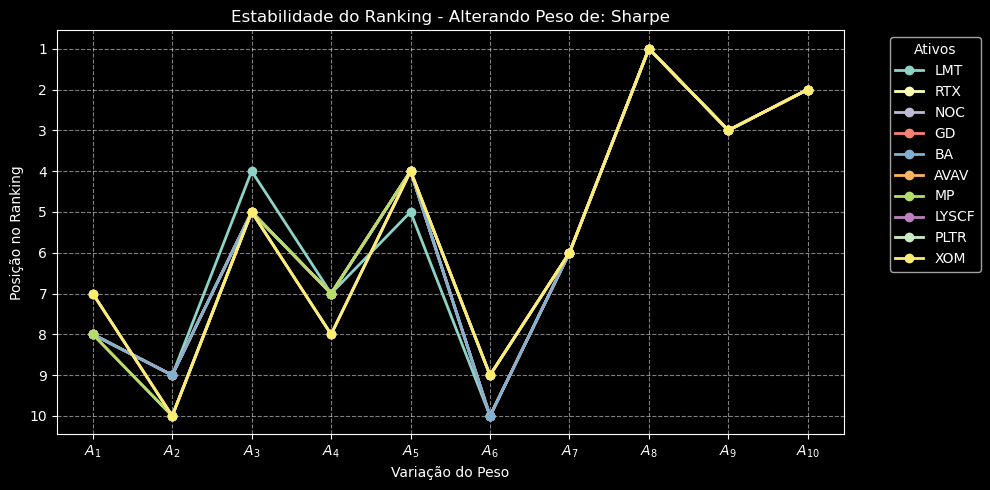


Análise de Sensibilidade: Max Drawdown (C4)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       8 |      8 |     8 |
| $A_{2}$           |    10 |    10 |    10 |    9 |    9 |      9 |    9 |       9 |      9 |     9 |
| $A_{3}$           |     5 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       7 |      7 |     7 |
| $A_{5}$           |     3 |     3 |     3 |    4 |    4 |      4 |    4 |       4 |      4 |     4 |
| $A_{6}$           |     9 |     9 |     9 |   10 |   10 |     10 |   10 |      10 |     10 |    10 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     1 

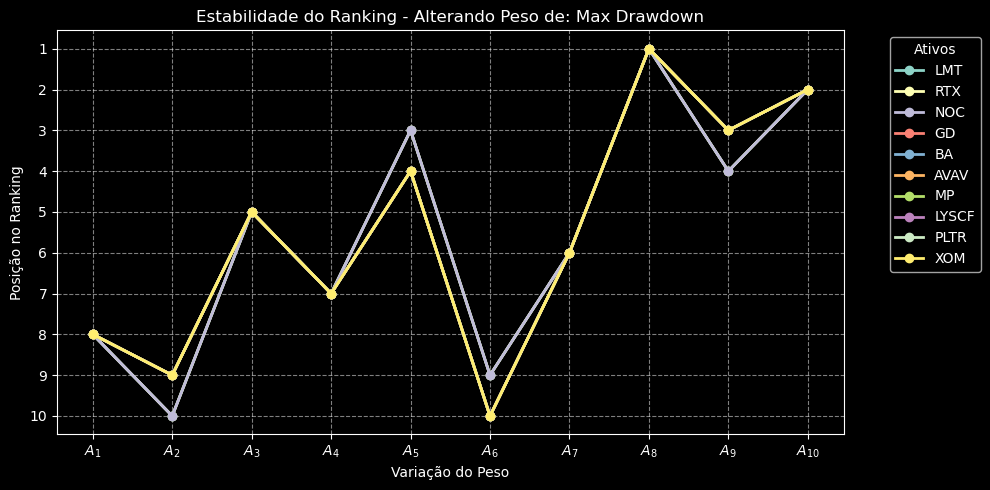


Análise de Sensibilidade concluída com sucesso!


In [ ]:
# --- BLOCO DE ANÁLISE DE SENSIBILIDADE (AJUSTADO E CORRIGIDO) ---
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pyrepo_mcda.sensitivity_analysis_weights_percentages import Sensitivity_analysis_weights_percentages
from pyrepo_mcda.mcda_methods import TOPSIS

# IMPORTANTE: Definindo os apelidos que faltavam
from pyrepo_mcda import normalizations as norms
from pyrepo_mcda import distance_metrics as dists

# 1. Parâmetros de Sensibilidade
percentages = np.arange(0.05, 0.55, 0.1)

# Agora o 'norms' e 'dists' estão definidos corretamente
method = TOPSIS(normalization_method=norms.minmax_normalization, distance_metric=dists.euclidean)
sensitivity_analysis = Sensitivity_analysis_weights_percentages()

# Nomes dos critérios para facilitar a leitura
list_crit_names = ['Retorno', 'Volatilidade', 'Sharpe', 'Max Drawdown']

# Dicionário para armazenar resumos de sensibilidade para o relatório final
sens_summary_for_ai = {}

# 2. Execução da Análise de Sensibilidade
for j in range(matrix.shape[1]):
    # Executa a análise para o critério j
    data_sens = sensitivity_analysis(matrix, weights, types, percentages, method, j, [-1, 1])

    # Prepara o cabeçalho
    header = ["Peso Modificado"] + list(tickers)

    print(f'\n' + '='*60)
    print(f'Análise de Sensibilidade: {list_crit_names[j]} (C{j+1})')
    print('='*60)

    # Exibe a tabela
    print(tabulate(data_sens, headers=header, tablefmt='github'))

    # Salva o desvio padrão do ranking para a IA saber qual critério é mais instável
    sens_summary_for_ai[list_crit_names[j]] = data_sens.std().mean()

    # 3. Gráfico de Estabilidade
    plt.figure(figsize=(10, 5))
    for i, ticker in enumerate(tickers):
        plt.plot(data_sens.index, data_sens.iloc[:, i], marker='o', label=ticker, linewidth=2)

    plt.gca().invert_yaxis()  # Rank 1 no topo é melhor para visualizar
    plt.title(f'Estabilidade do Ranking - Alterando Peso de: {list_crit_names[j]}', fontsize=12)
    plt.xlabel('Variação do Peso', fontsize=10)
    plt.ylabel('Posição no Ranking', fontsize=10)
    plt.yticks(range(1, len(tickers) + 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ativos")
    plt.tight_layout()
    plt.show()

print("\nAnálise de Sensibilidade concluída com sucesso!")


----------------------------------------
GRÁFICOS DE APOIO: Retorno
----------------------------------------


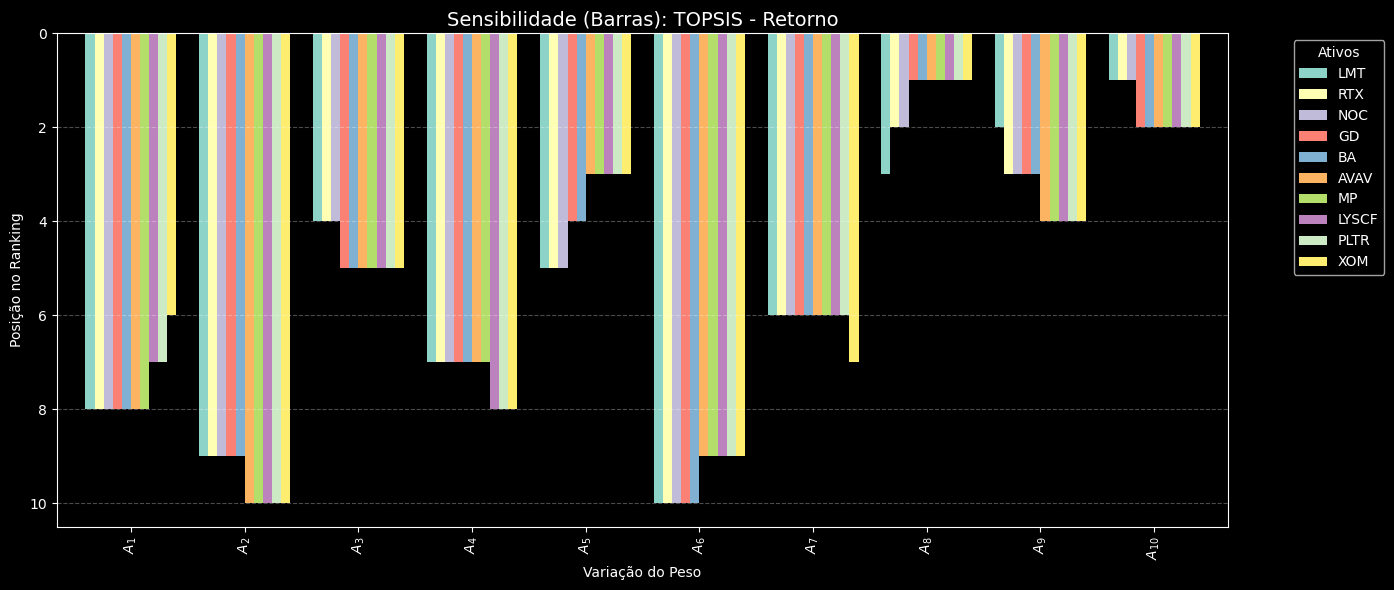

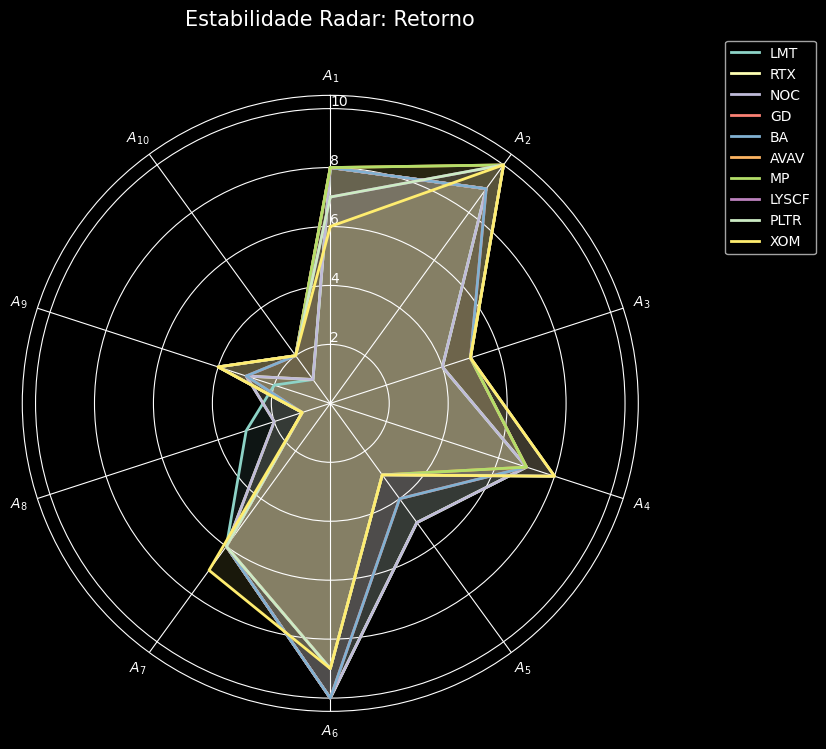


----------------------------------------
GRÁFICOS DE APOIO: Volatilidade
----------------------------------------


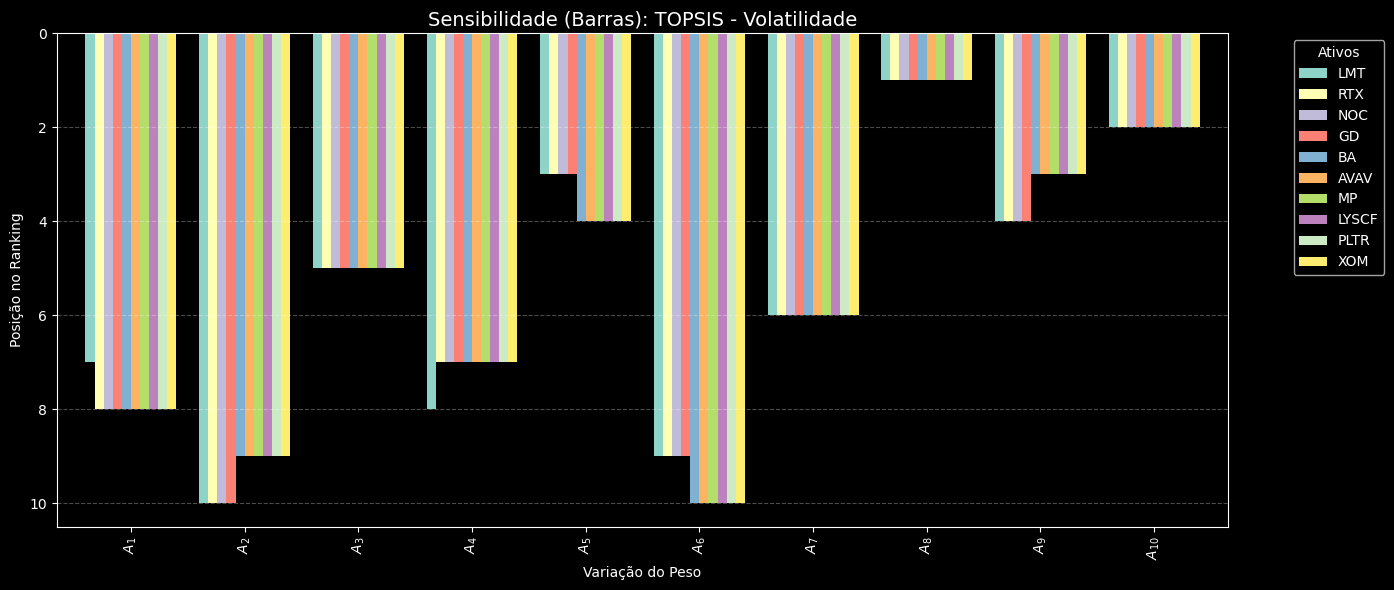

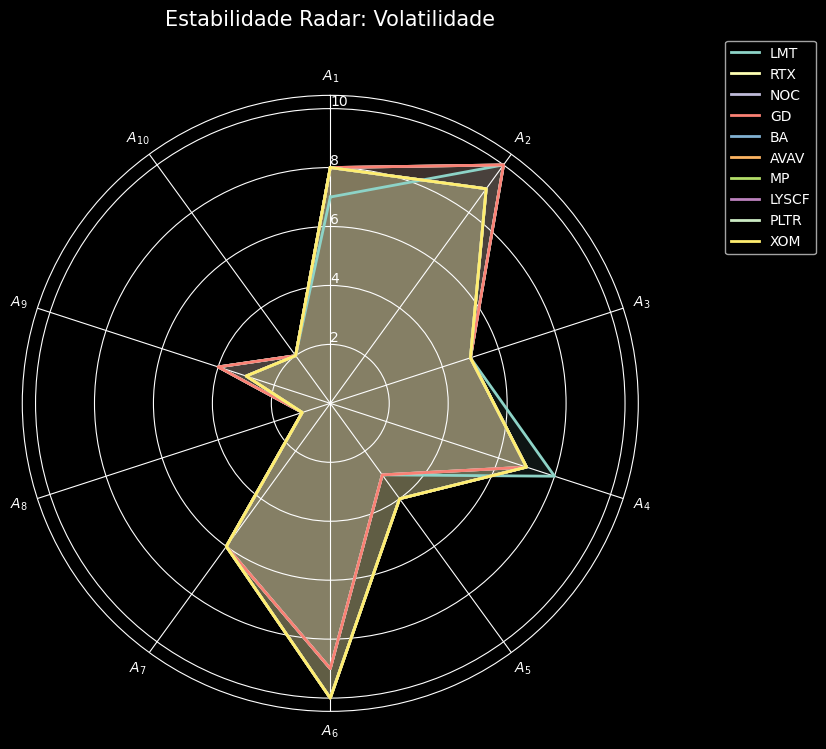


----------------------------------------
GRÁFICOS DE APOIO: Sharpe
----------------------------------------


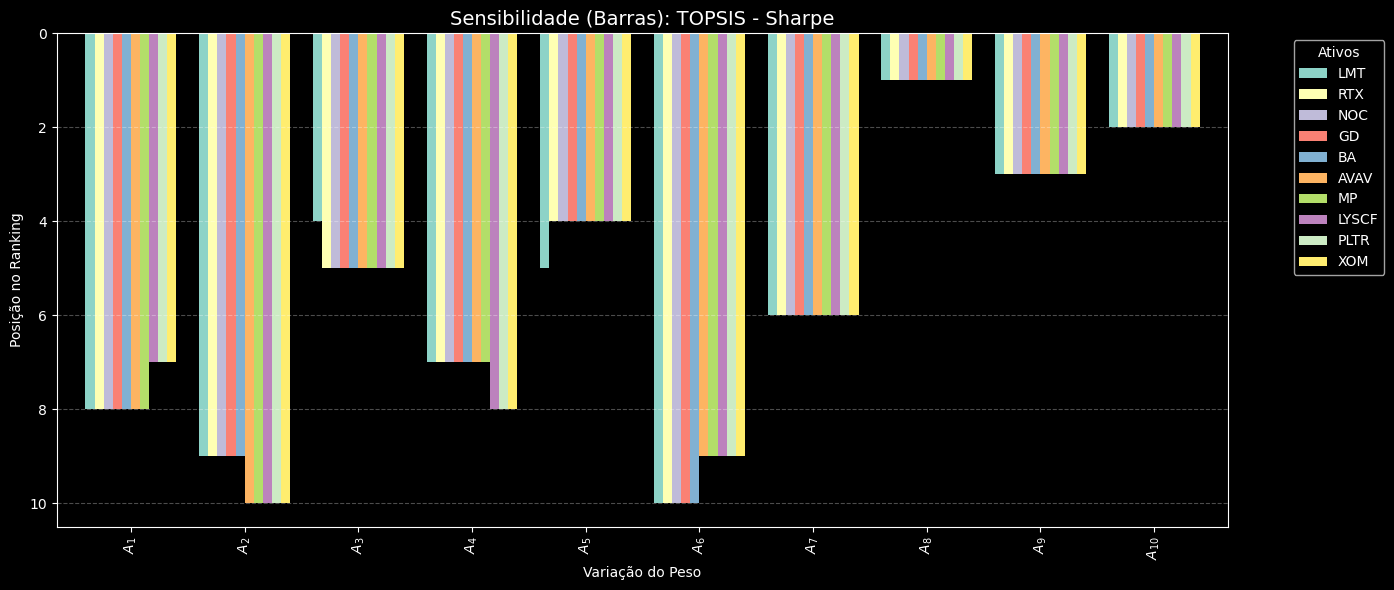

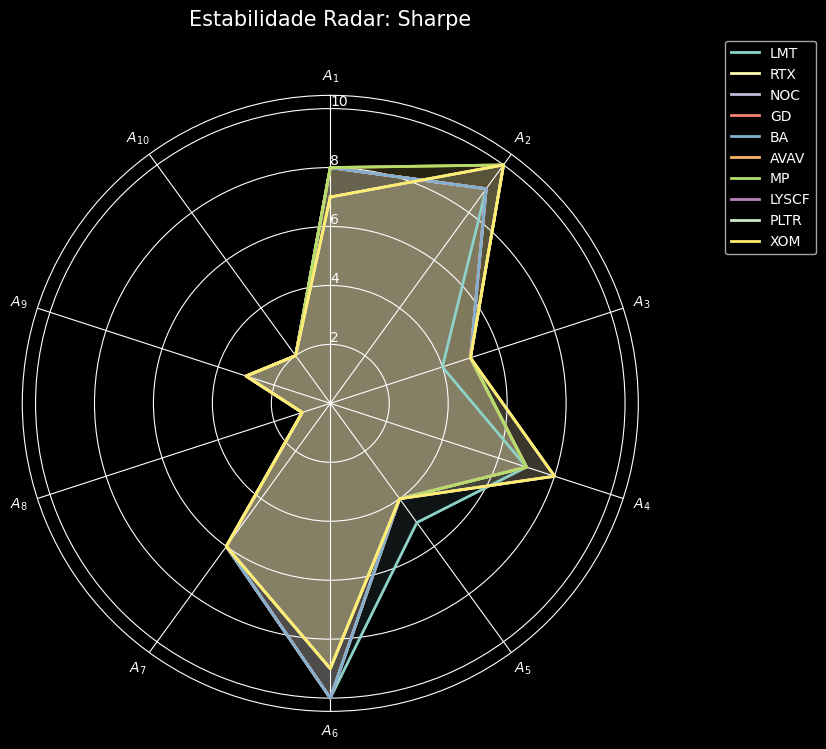


----------------------------------------
GRÁFICOS DE APOIO: Max Drawdown
----------------------------------------


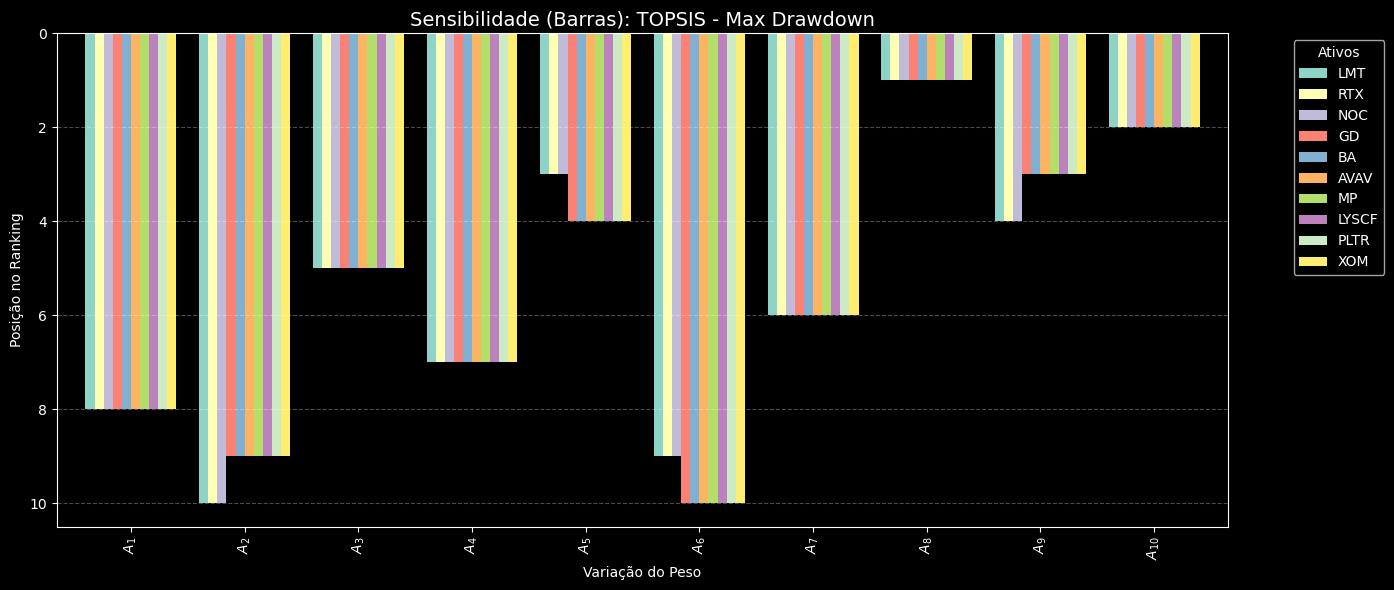

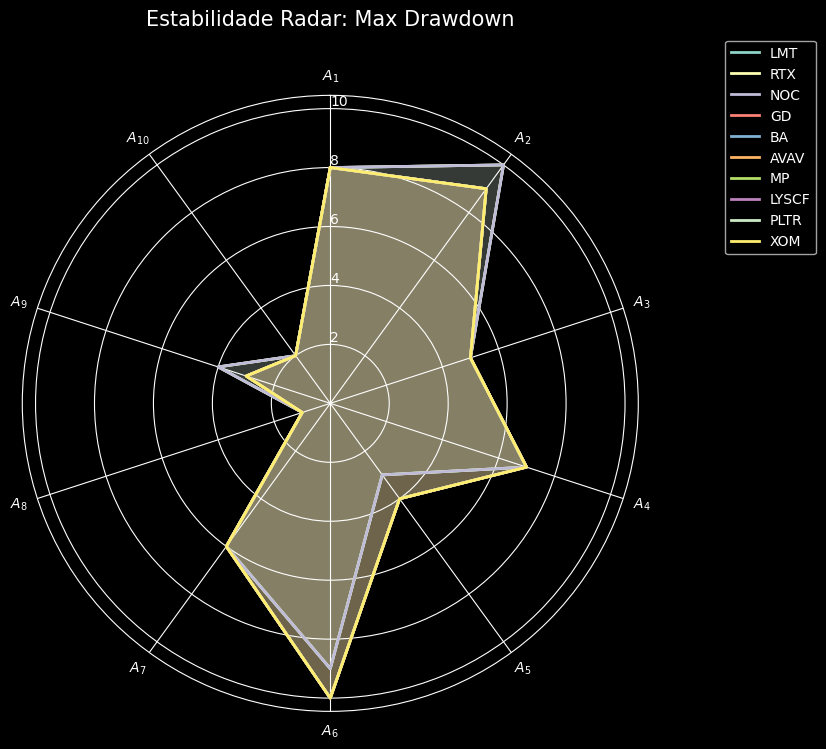

In [ ]:
# --- BLOCO: VISUALIZAÇÕES DE BARRAS E RADAR ---
import math

def plot_barplot_sensitivity(data, method_name, crit_name):
    """Gera gráfico de barras para análise de sensibilidade."""
    # Plotando os rankings; quanto menor a barra, melhor a posição
    ax = data.plot(kind='bar', figsize=(14, 6), width=0.8)
    plt.title(f'Sensibilidade (Barras): {method_name} - {crit_name}', fontsize=14)
    plt.xlabel('Variação do Peso')
    plt.ylabel('Posição no Ranking')
    plt.gca().invert_yaxis()  # Rank 1 no topo
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ativos")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_radar(data, title):
    """Gera gráfico de radar para estabilidade do ranking."""
    categories = data.index.astype(str).tolist()
    N = len(categories)

    # Define os ângulos para cada eixo do radar
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1] # Fecha o círculo

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    for ticker in data.columns:
        values = data[ticker].tolist()
        values += values[:1] # Fecha o polígono
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=ticker)
        # Preenchimento sólido para evitar problemas de transparência em alguns backends
        ax.fill(angles, values, alpha=0.1)

    # Configurações do gráfico de Radar
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)

    # No Radar de Ranking, quanto mais perto do centro (centro = 1), melhor o ativo
    plt.title(title, size=15, color='white', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- EXECUÇÃO DAS VISUALIZAÇÕES ---
# O j loop assume que 'matrix' e 'sensitivity_analysis' estão no contexto do Jupyter
for j in range(matrix.shape[1]):
    # data_sens gerado conforme a documentação da pyrepo-mcda
    data_sens = sensitivity_analysis(matrix, weights, types, percentages, method, j, [-1, 1])
    data_sens.columns = tickers # Aplica os nomes dos ativos de guerra/estratégia

    print(f"\n" + "-"*40)
    print(f"GRÁFICOS DE APOIO: {list_crit_names[j]}")
    print("-"*40)

    # 1. Gráfico de Barras
    plot_barplot_sensitivity(data_sens, method.__class__.__name__, list_crit_names[j])

    # 2. Gráfico de Radar
    plot_radar(data_sens, f'Estabilidade Radar: {list_crit_names[j]}')


EXECUTANDO TOPSIS COM MÚLTIPLAS MÉTRICAS DE DISTÂNCIA
|       |   Euclidean |   Manhattan |   Hausdorff |   Chebyshev |   Bray curtis |   Canberra |   Lorentzian |   Jaccard |
|-------|-------------|-------------|-------------|-------------|---------------|------------|--------------|-----------|
| LMT   |           8 |           8 |           8 |           8 |             8 |          7 |            8 |         7 |
| RTX   |           9 |           9 |           9 |           9 |             9 |         10 |            9 |        10 |
| NOC   |           5 |           4 |           5 |           5 |             4 |          3 |            4 |         5 |
| GD    |           7 |           7 |           7 |           7 |             7 |          6 |            7 |         8 |
| BA    |           4 |           5 |           3 |           3 |             5 |          5 |            5 |         3 |
| AVAV  |          10 |          10 |          10 |          10 |            10 |          

<Figure size 1200x600 with 0 Axes>

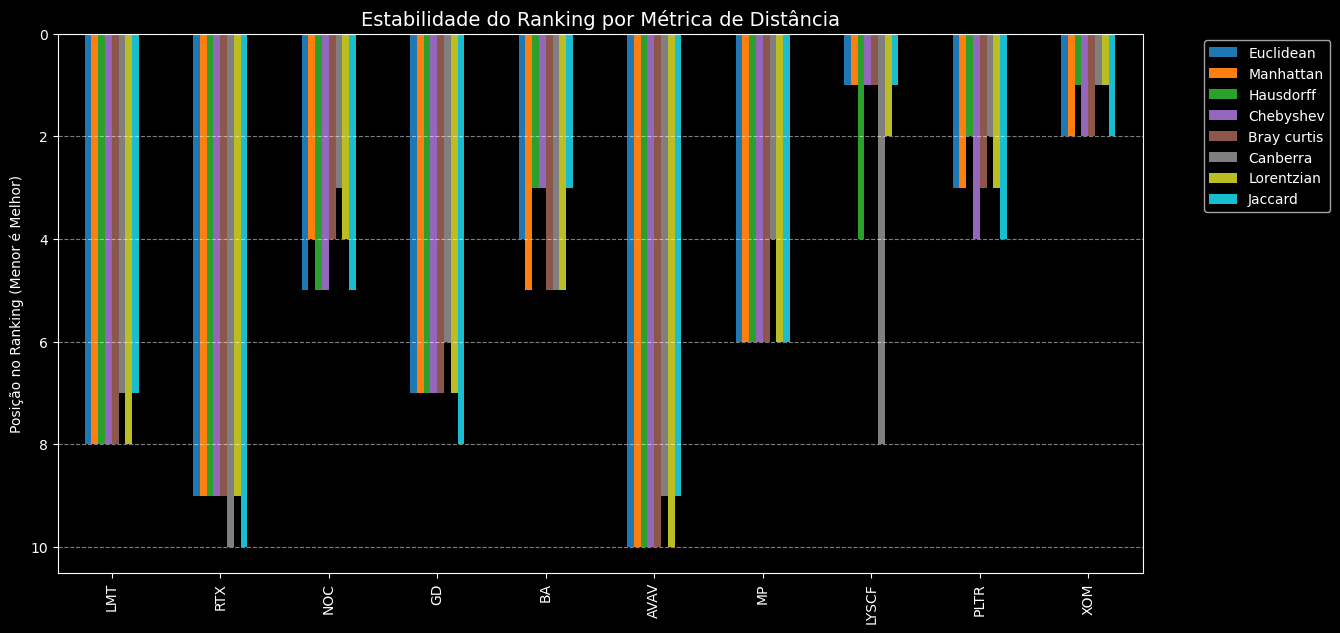

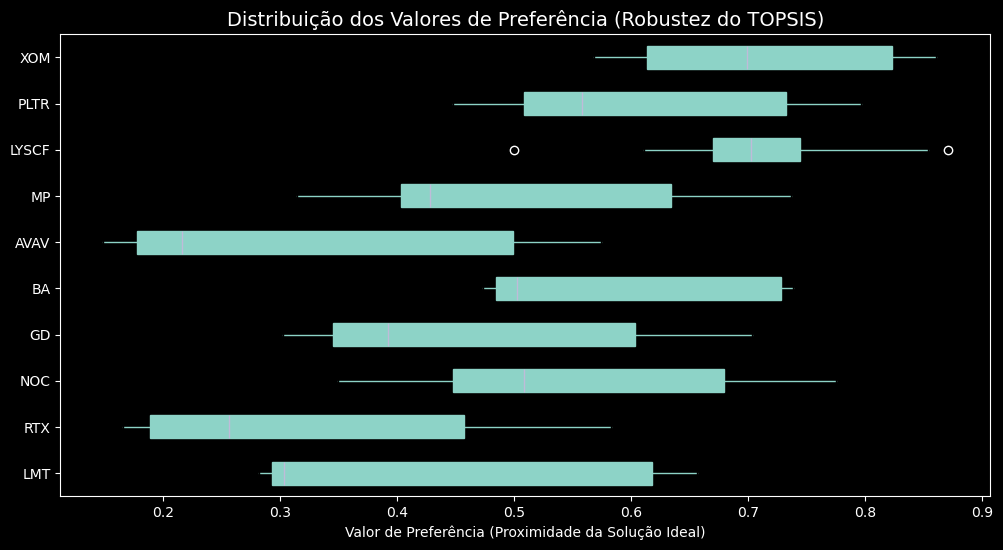

In [ ]:
# --- BLOCO: ANÁLISE COMPARATIVA DE MÉTRICAS DE DISTÂNCIA ---
from pyrepo_mcda import distance_metrics as dists

# 1. Lista de métricas de distância para teste de robustez
distance_metrics = [
    dists.euclidean,    # Padrão: linha reta
    dists.manhattan,    # Distância em quarteirões
    dists.hausdorff,    # Mede a maior distância entre conjuntos
    dists.chebyshev,    # Foca no critério com maior discrepância
    dists.bray_curtis,  # Comum em ecologia e séries temporais
    dists.canberra,     # Sensível a valores próximos de zero
    dists.lorentzian,   # Menos sensível a outliers
    dists.jaccard       # Útil para medir similaridade
]

# 2. Inicialização dos DataFrames para coletar resultados
# tickers foi definido anteriormente com ativos como LMT, RTX, NVDA, etc.
df_preferences = pd.DataFrame(index = tickers)
df_rankings = pd.DataFrame(index = tickers)

print("\n" + "="*60)
print("EXECUTANDO TOPSIS COM MÚLTIPLAS MÉTRICAS DE DISTÂNCIA")
print("="*60)

# 3. Loop de execução comparativa
for distance_metric in distance_metrics:
    # Cria o objeto TOPSIS variando apenas a métrica de distância
    topsis = TOPSIS(normalization_method = norms.minmax_normalization, distance_metric = distance_metric)

    # matrix, weights e types devem estar carregados no contexto
    pref = topsis(matrix, weights, types)
    rank = rank_preferences(pref, reverse = True)

    # Formata o nome da métrica para as colunas do DataFrame
    metric_name = distance_metric.__name__.capitalize().replace('_', ' ')
    df_preferences[metric_name] = pref
    df_rankings[metric_name] = rank

# Exibe o DataFrame de Rankings para comparação visual rápida
print(tabulate(df_rankings, headers='keys', tablefmt='github'))

# 4. Visualização de Resultados
# Gráfico de Barras para os Rankings
plt.figure(figsize=(12, 6))
df_rankings.plot(kind='bar', figsize=(14, 7), colormap='tab10')
plt.title('Estabilidade do Ranking por Métrica de Distância', fontsize=14)
plt.ylabel('Posição no Ranking (Menor é Melhor)')
plt.gca().invert_yaxis() # Rank 1 no topo
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Gráfico de Caixa (Boxplot) para Distribuição de Preferências
# Ajuda a ver a dispersão das notas dadas a cada ativo
plt.figure(figsize=(12, 6))
df_preferences.T.boxplot(grid=False, vert=False, patch_artist=True)
plt.title('Distribuição dos Valores de Preferência (Robustez do TOPSIS)', fontsize=14)
plt.xlabel('Valor de Preferência (Proximidade da Solução Ideal)')
plt.show()

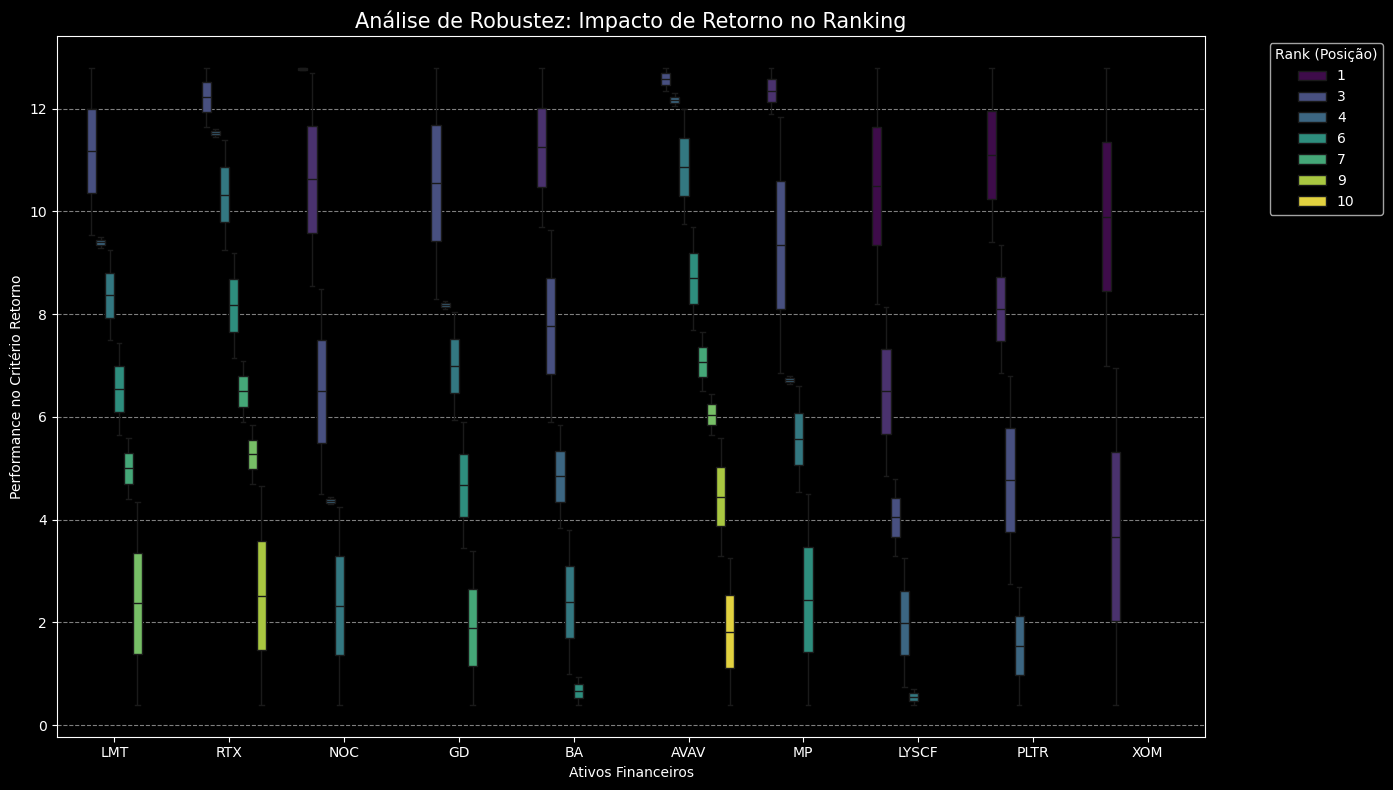

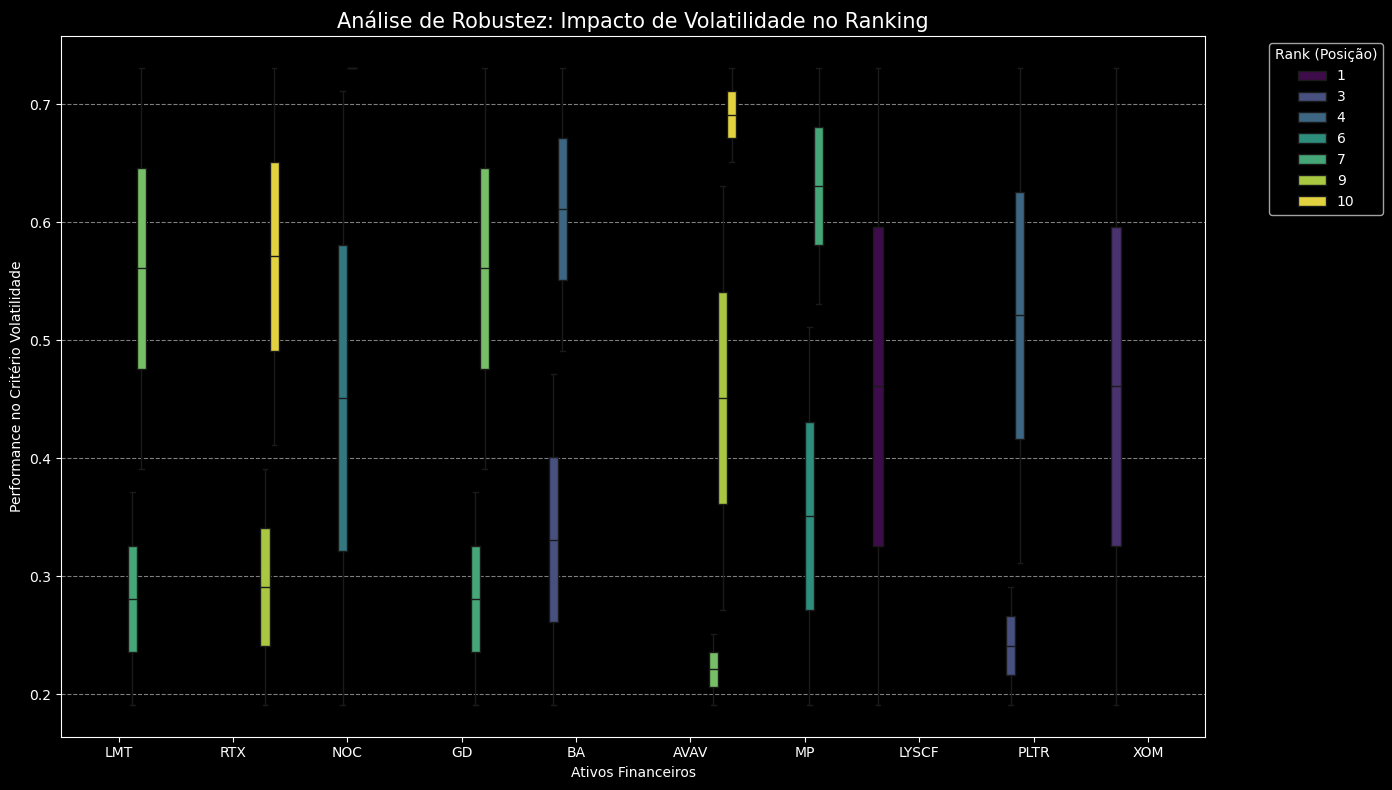

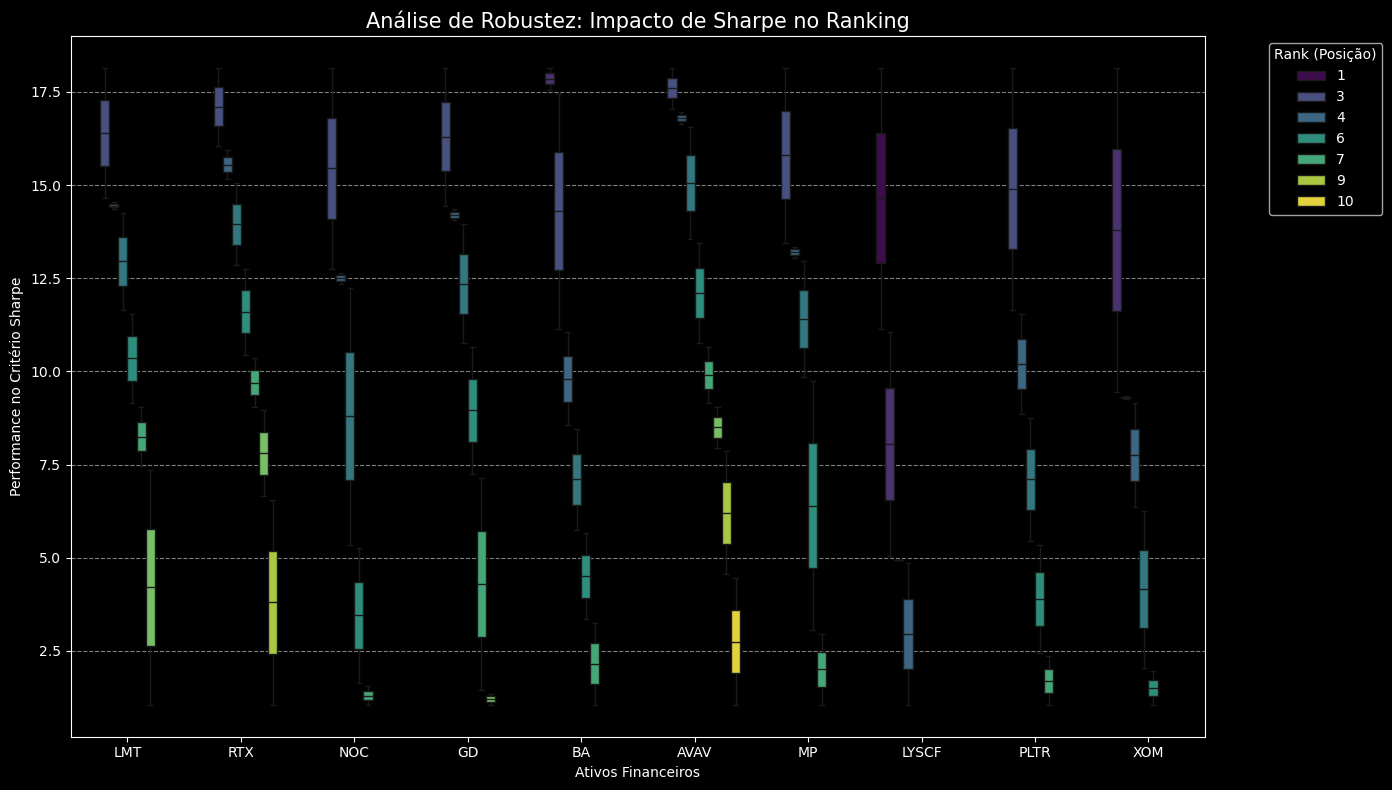

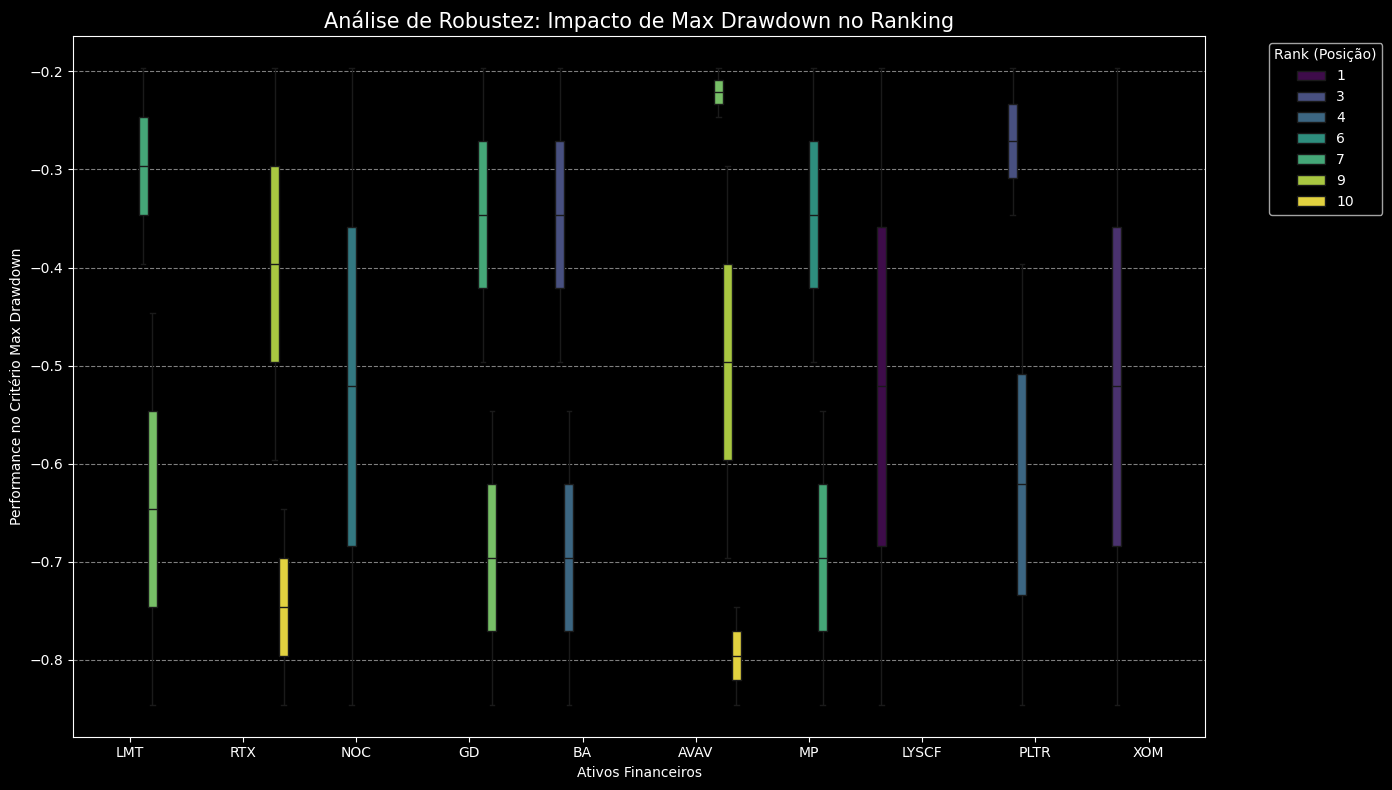

In [ ]:
# --- BLOCO: ANÁLISE DE ROBUSTEZ (SIMULAÇÃO DE PERFORMANCE) ---
import copy
import seaborn as sns

# 1. Configuração do Ambiente de Simulação
topsis = TOPSIS(normalization_method=norms.minmax_normalization, distance_metric=dists.euclidean)

# Definição dos limites (Bounds) baseados na matriz de mercado atual
bounds_min = np.amin(matrix, axis=0)
bounds_max = np.amax(matrix, axis=0)
bounds = np.vstack((bounds_min, bounds_max))

# Identificação das Soluções Ideal (ISP) e Anti-Ideal (ASP)
isp = np.zeros(matrix.shape[1])
isp[types == 1] = bounds[1, types == 1]
isp[types == -1] = bounds[0, types == -1]

asp = np.zeros(matrix.shape[1])
asp[types == 1] = bounds[0, types == 1]
asp[types == -1] = bounds[1, types == -1]

# 2. Definição do Passo de Simulação para cada Critério
# Ajustado para os valores reais (Retorno, Volatilidade, Sharpe, MDD)
# j: passo_da_simulação
indexes = {
    0 : 0.05,  # Passo para Retorno (5%)
    1 : 0.02,  # Passo para Volatilidade (2%)
    2 : 0.1,   # Passo para Sharpe
    3 : 0.05   # Passo para Max Drawdown
}

def plot_boxplot_simulation(df, x_col, y_col, hue_col, xlabel, ylabel, title, filename):
    """Gera visualização de robustez similar ao exemplo visualizations.py"""
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=x_col, y=y_col, hue=hue_col, data=df, palette='viridis')
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Rank (Posição)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 3. Execução da Simulação por Critério
for j in range(matrix.shape[1]):
    change_val = indexes[j]
    dict_results_sim = {'Rank': [], 'Performance': [], 'Alternative': []}

    for i in range(matrix.shape[0]):
        # Gera o vetor de simulação do ponto mais baixo ao mais alto do mercado
        vec = np.arange(asp[j], isp[j] + (types[j] * change_val), types[j] * change_val)

        for v in vec:
            new_matrix = copy.deepcopy(matrix)
            new_matrix[i, j] = v
            pref = topsis(new_matrix, weights, types)
            rank = rank_preferences(pref, reverse=True)

            dict_results_sim['Rank'].append(rank[i])
            dict_results_sim['Performance'].append(v)
            dict_results_sim['Alternative'].append(tickers[i])

    df_results_sim = pd.DataFrame(dict_results_sim)

    # Visualização da Robustez
    plot_boxplot_simulation(
        df_results_sim,
        'Alternative',
        'Performance',
        'Rank',
        'Ativos Financeiros',
        f'Performance no Critério {list_crit_names[j]}',
        f'Análise de Robustez: Impacto de {list_crit_names[j]} no Ranking',
        f'robustness_{j+1}'
    )

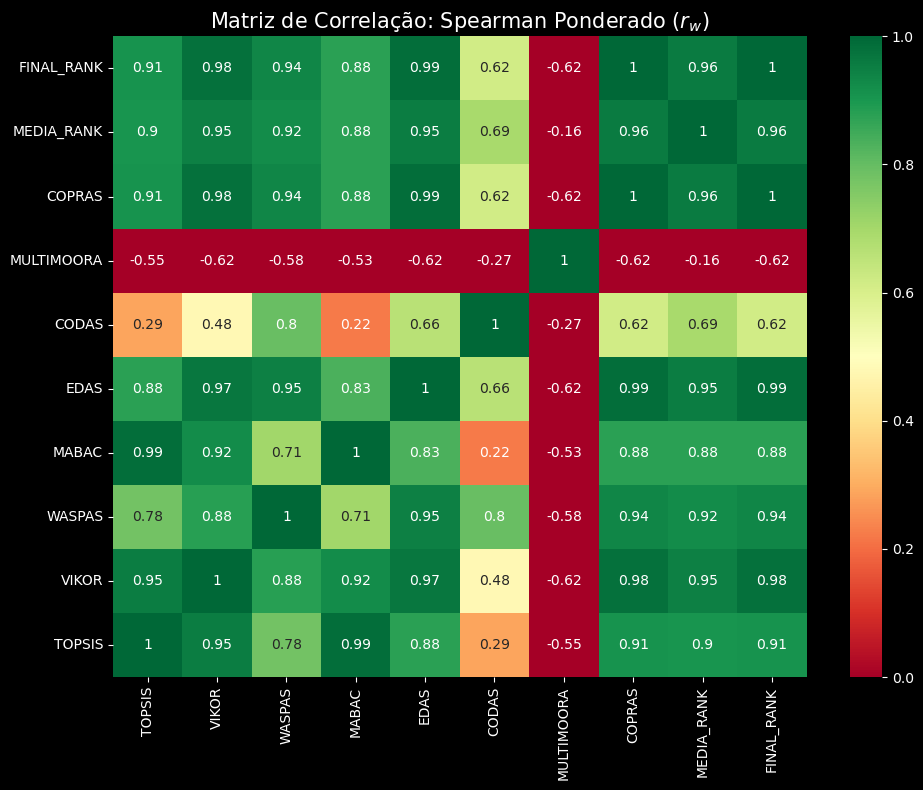

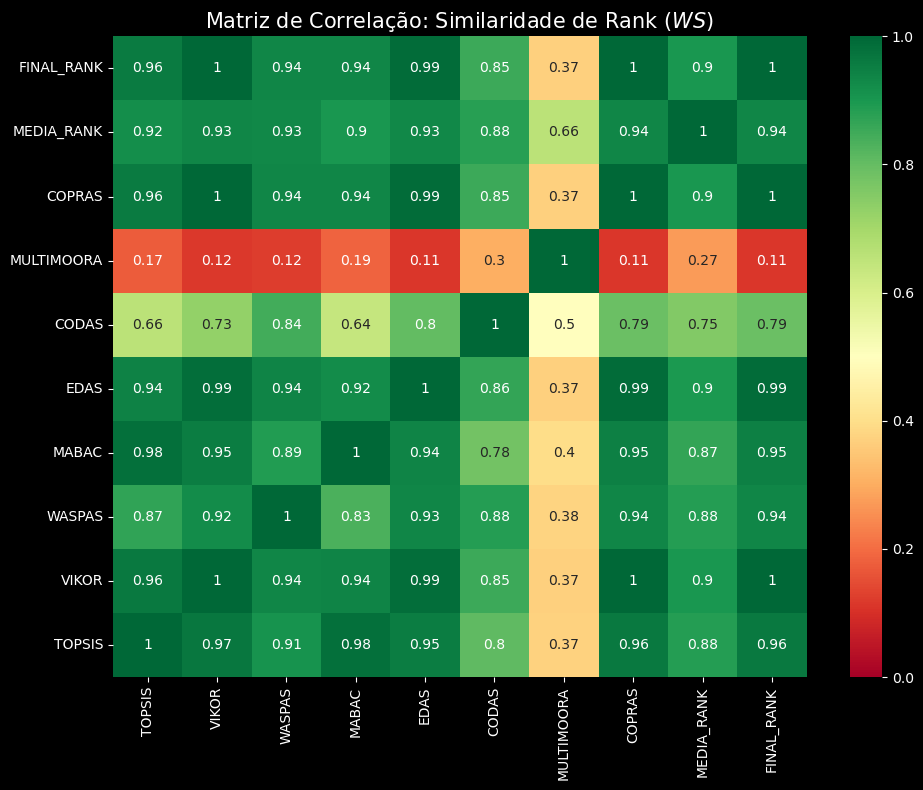

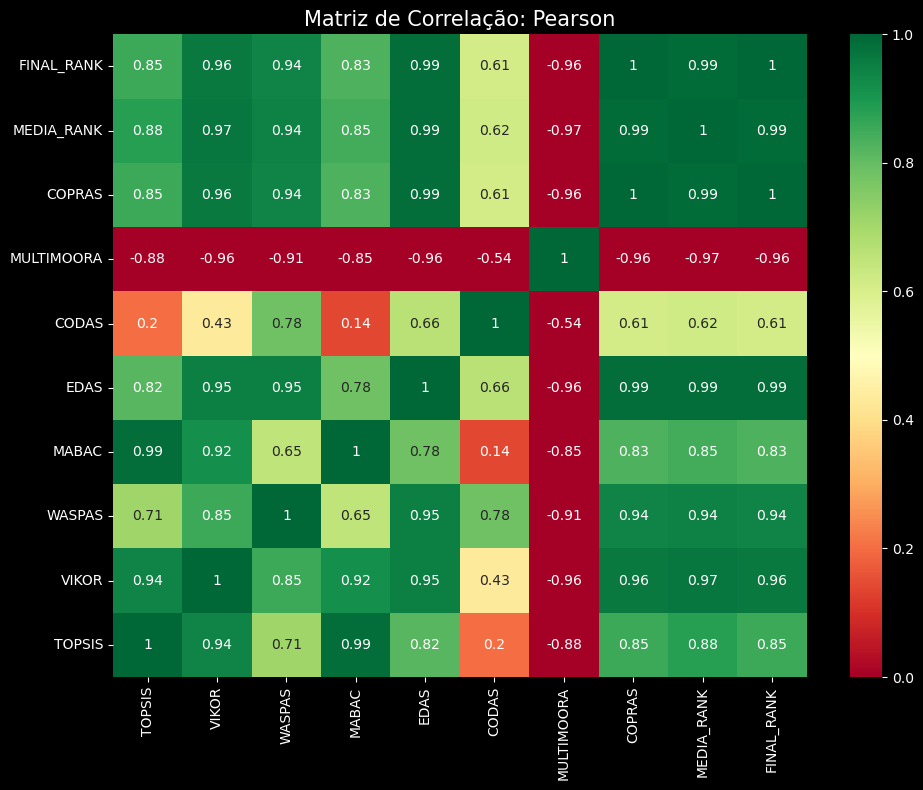

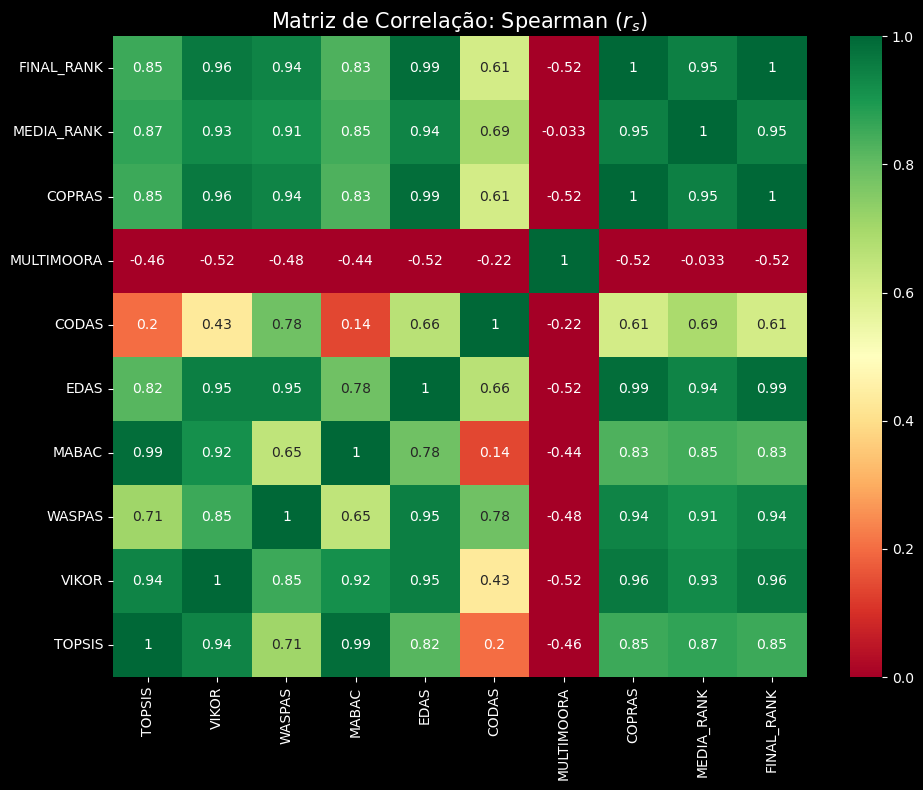

In [ ]:
# --- BLOCO: CORRELAÇÕES DE RESULTADOS E MAPAS DE CALOR ---
import copy
import seaborn as sns
from pyrepo_mcda import correlations as corrs

# 1. Preparação dos dados de ranking
# 'df_ranks' contém os rankings de todos os métodos (TOPSIS, VIKOR, etc.)
data = copy.deepcopy(df_ranks)
method_types = list(data.columns)

# Dicionários para armazenar as matrizes de correlação
dict_rw = {el: [] for el in method_types}
dict_ws = {el: [] for el in method_types}
dict_pearson = {el: [] for el in method_types}
dict_spearman = {el: [] for el in method_types}

# 2. Cálculo das Correlações entre os pares de métodos
for i, j in [(i, j) for i in method_types[::-1] for j in method_types]:
    dict_rw[j].append(corrs.weighted_spearman(data[i], data[j]))
    dict_ws[j].append(corrs.WS_coeff(data[i], data[j]))
    dict_pearson[j].append(corrs.pearson_coeff(data[i], data[j]))
    dict_spearman[j].append(corrs.spearman(data[i], data[j]))

# Transformação em DataFrames para visualização
df_rw = pd.DataFrame(dict_rw, index=method_types[::-1])
df_ws = pd.DataFrame(dict_ws, index=method_types[::-1])
df_pearson = pd.DataFrame(dict_pearson, index=method_types[::-1])
df_spearman = pd.DataFrame(dict_spearman, index=method_types[::-1])

# 3. Função para desenhar os Mapas de Calor (Heatmaps)
def draw_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='RdYlGn', vmin=0, vmax=1)
    plt.title(f'Matriz de Correlação: {title}', fontsize=15)
    plt.tight_layout()
    plt.show()

# 4. Visualização dos Heatmaps
draw_heatmap(df_rw, r'Spearman Ponderado ($r_w$)')
draw_heatmap(df_ws, r'Similaridade de Rank ($WS$)')
draw_heatmap(df_pearson, r'Pearson')
draw_heatmap(df_spearman, r'Spearman ($r_s$)')

In [ ]:
import os
import sys

# 1. IMPORTAÇÕES ATUALIZADAS (Novos Namespaces)
from langchain_ollama import OllamaLLM, OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, UnstructuredEPubLoader, DirectoryLoader
from langchain_community.vectorstores import DocArrayInMemorySearch


# 2. CONFIGURAÇÃO DO CÉREBRO (LLAMA 3 LOCAL)
# A classe moderna agora é OllamaLLM
llm = OllamaLLM(model="llama3", temperature=0)

# 3. CARREGAMENTO AUTOMÁTICO DA PASTA RAG
path_rag = r"C:\Users\gusta\Desktop\TRADER\rag_mcda"

print(f"Varrendo a biblioteca GridFlow em: {path_rag}...")

# DirectoryLoader atualizado para os novos padrões de loaders
pdf_loader = DirectoryLoader(path_rag, glob="**/*.pdf", loader_cls=PyPDFLoader)
epub_loader = DirectoryLoader(path_rag, glob="**/*.epub", loader_cls=UnstructuredEPubLoader)

# Unificando documentos
documentos = pdf_loader.load() + epub_loader.load()

# Splitter importado do pacote específico 'langchain_text_splitters'
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
blocos_texto = text_splitter.split_documents(documentos)

# 4. CRIAÇÃO DA BASE DE CONHECIMENTO (Embeddings locais)
embeddings = OllamaEmbeddings(model="llama3")
vectorstore = DocArrayInMemorySearch.from_documents(blocos_texto, embeddings)

# 5. CONTEXTO TÉCNICO (MCDA)
# Injetando seus resultados de Correlação, Sensibilidade e Rankings
contexto_mcda = f"""
DADOS DO SISTEMA GRIDFLOW:
- Rankings Atuais (10 métodos): {df_ranks.to_string()}
- Matriz de Correlação (RW): {df_rw.to_string()}
- Estabilidade: Resultados de Sensibilidade (Radar) e Robustez (Métricas de Distância) processados.
- Ativo Líder: {df_ranks['FINAL_RANK'].idxmin()}
"""

# 6. TEMPLATE DO PROMPT PROFISSIONAL
template_relatorio = """
Você é o Analista Chefe de Inteligência Artificial da GridFlow Software.
Sua tarefa é gerar um relatório executivo cruzando a teoria dos manuais (PDF/EPUB) com os dados estatísticos.

CONTEXTO TÉCNICO DOS DOCUMENTOS:
{context}

DADOS DA ANÁLISE:
{question}

ESTRUTURA DO RELATÓRIO:
1. ANÁLISE DE CONVERGÊNCIA: O quão unânime é a escolha do ativo líder segundo a correlação?
2. RESILIÊNCIA E ROBUSTEZ: Baseado nas métricas de distância e sensibilidade, o ativo é estável?
3. VERDITO ESTRATÉGICO: Use os livros da pasta (Schopenhauer, Geopolítica, etc) para dar profundidade.
4. RECOMENDAÇÃO FINAL: Decisão de alocação para o robô de trading.
"""

PROMPT = PromptTemplate(template=template_relatorio, input_variables=["context", "question"])

# 7. ORQUESTRAÇÃO DA CHAIN
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    combine_docs_chain_kwargs={"prompt": PROMPT}
)

# 8. GERAÇÃO E SALVAMENTO
print("Llama 3 cruzando literatura com estatística... Aguarde.")
pergunta_contextualizada = f"Gere o relatório completo considerando estes dados: {contexto_mcda}"

# Chamada moderna da chain
resposta = qa_chain.invoke({"question": pergunta_contextualizada, "chat_history": []})

print("\n" + "="*80)
print("RELATÓRIO TÉCNICO GRIDFLOW - GERADO LOCALMENTE")
print("="*80)
print(resposta['answer'])

# Salva o arquivo MD
nome_arquivo = os.path.join(path_rag, "Relatorio_Final_MCDA_2026.md")
with open(nome_arquivo, "w", encoding="utf-8") as f:
    f.write(resposta['answer'])

print(f"\nSucesso! Relatório salvo em: {nome_arquivo}")

Varrendo a biblioteca GridFlow em: C:\Users\gusta\Desktop\TRADER\rag_mcda...


incorrect startxref pointer(4)
parsing for Object Streams
